  Cloning https://github.com/Deltares/hatyan (to revision development) to /tmp/pip-req-build-tegry29d
  Running command git clone -q https://github.com/Deltares/hatyan /tmp/pip-req-build-tegry29d
  Running command git checkout -b development --track origin/development
  Switched to a new branch 'development'
  Branch 'development' set up to track remote branch 'development' from 'origin'.
  Created wheel for hatyan: filename=hatyan-2.5.32-py3-none-any.whl size=103180 sha256=c595850c2f2ac81780180f2fecd71d23df515367c34264775b4300ff7d4c2fd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-spwxq9d0/wheels/14/c3/d2/0f48da11519536120be062dd26a83ba38a58584dadd3cc2253
Successfully built hatyan
  Attempting uninstall: hatyan
    Found existing installation: hatyan 2.5.31
    Uninstalling hatyan-2.5.31:
      Successfully uninstalled hatyan-2.5.31


--------------------------------------------------
cropping timeseries
timeseries contents:
                            values
2017-01-01 00:00:00.000000   1.560
2017-01-01 01:00:00.028800   1.850
2017-01-01 01:59:59.971200   1.950
2017-01-01 03:00:00.000000   1.680
2017-01-01 04:00:00.028800   1.020
...                            ...
2018-12-30 19:59:59.971200   0.670
2018-12-30 21:00:00.000000   0.020
2018-12-30 22:00:00.028800  -0.550
2018-12-30 22:59:59.971200  -0.993
2018-12-31 00:00:00.000000  -1.290

[17497 rows x 1 columns]
timeseries # unique timesteps: 2
timeseries unique timesteps (minutes):
{60.00048, 60.0}
timeseries validity: all time intervals are in increasing order and are never equal
timeseries length: 17497
timeseries # nonan: 17497
timeseries % nonan: 100.0%
timeseries # nan: 0
timeseries % nan: 0.0%
--------------------------------------------------
running: get_components_from_ts
analysis_peryear=True, separate years are automatically determined from unique calend

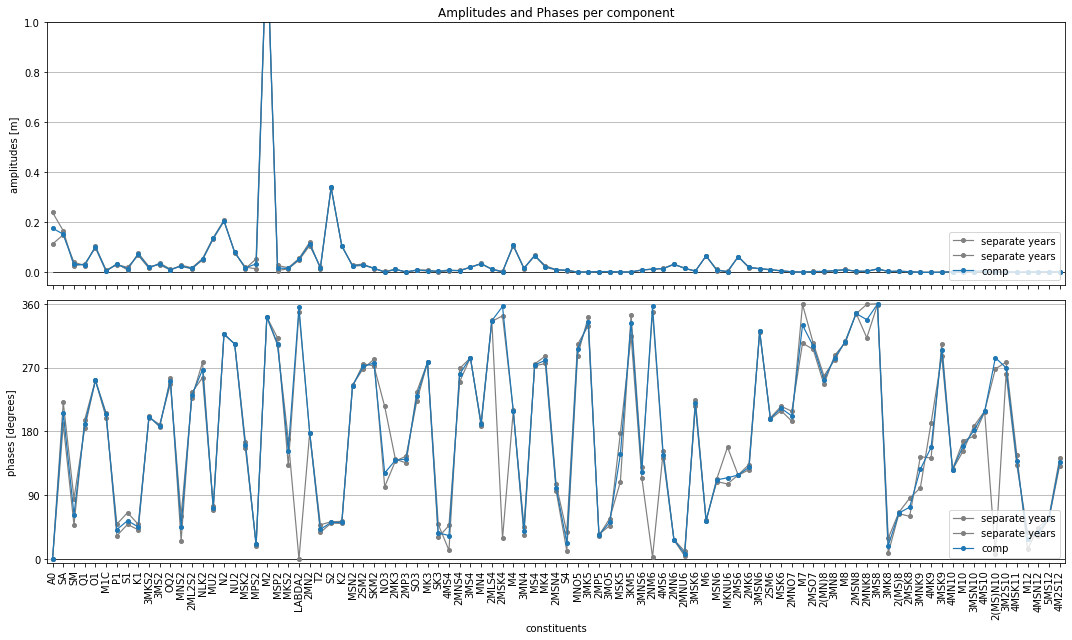

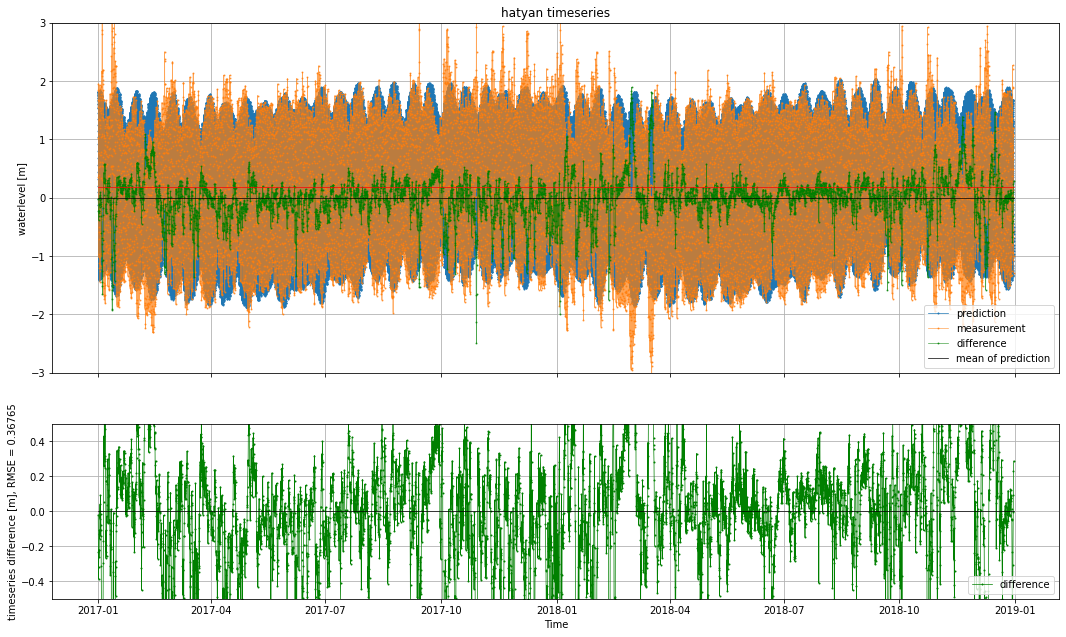

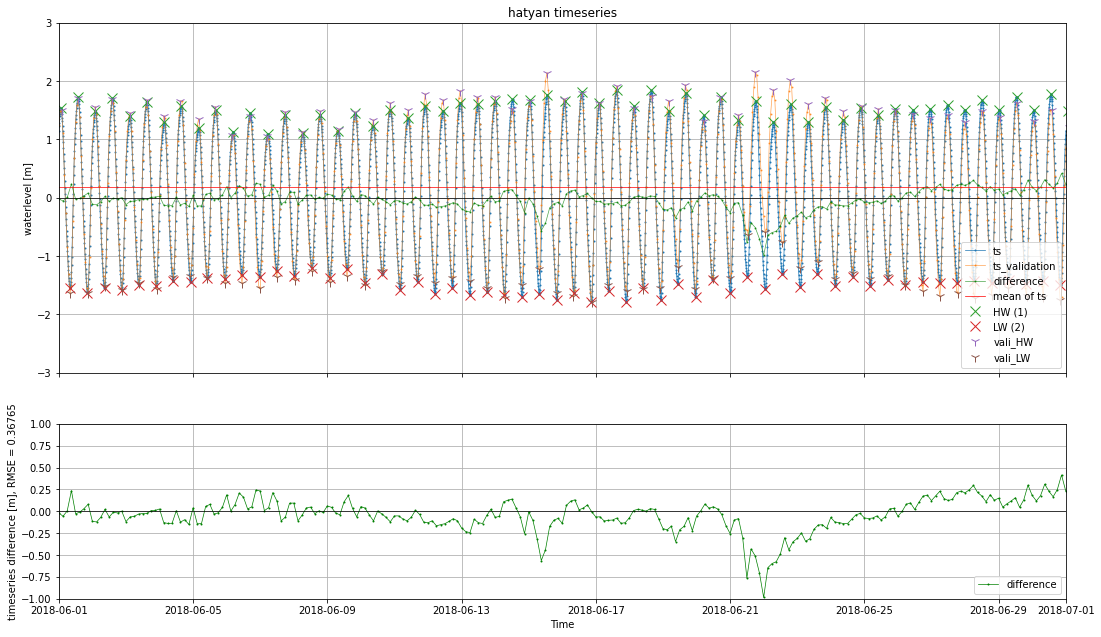

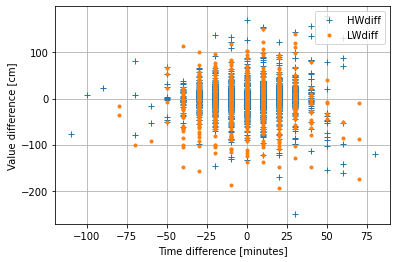

In [5]:
import datetime as dt
import pandas as pd
from netCDF4 import Dataset, num2date
import hatyan
hatyan.close('all')

#defining a list of the components to be analysed (can also be 'half_year' and others, 'year' contains 94 components and the mean H0)
const_list = hatyan.get_const_list_hatyan('year')

#reading and editing time series, results in a pandas DataFrame a 'values' column (water level in meters) and a pd.DatetimeIndex as index (timestamps as datetime.datetime)
file_data_meas = 'http://uhslc.soest.hawaii.edu:80/opendap/rqds/global/hourly/h825a.nc' #Cuxhaven dataset from UHSLC database #os.path.join(r'n:\\Deltabox\\Bulletin\\veenstra\\VLISSGN_waterlevel_20101201_20140101.noos')
times_ext = [dt.datetime(2017,1,1),dt.datetime(2018,12,31)]
timestep_min = 10
ts_data = Dataset(file_data_meas)
ts_data_values = ts_data['sea_level'][0,-18000:]/1000-5 #correct from mm to meters and for 5m offset
ts_data_times = num2date(ts_data['time'][-18000:],units=ts_data['time'].units, only_use_cftime_datetimes=False)
ts_meas = pd.DataFrame({'values':ts_data_values},index=ts_data_times)
#ts_meas = hatyan.resample_timeseries(ts_meas, timestep_min=60) #resampling only works well when timesteps are rounded to seconds
ts_meas = hatyan.crop_timeseries(ts=ts_meas, times_ext=times_ext)

#tidal analysis and plotting of results. commented: saving figure  
comp_frommeas, comp_allyears = hatyan.get_components_from_ts(ts=ts_meas, const_list=const_list, nodalfactors=True, return_allyears=True, fu_alltimes=True, analysis_peryear=True)
fig,(ax1,ax2) = hatyan.plot_components(comp=comp_frommeas, comp_allyears=comp_allyears)
fig.savefig('components.png')

#tidal prediction and plotting of results. commented: saving figure and writing to netCDF
ts_prediction = hatyan.prediction(comp=comp_frommeas, nodalfactors=True, fu_alltimes=True, times_ext=times_ext, timestep_min=timestep_min)
fig, (ax1,ax2) = hatyan.plot_timeseries(ts=ts_prediction, ts_validation=ts_meas)
ax1.legend(['prediction','measurement','difference','mean of prediction'])
ax2.set_ylim(-0.5,0.5)
#fig.savefig('prediction.png')

#calculation of HWLW and plotting of results. commented: saving figure
ts_ext_meas = hatyan.calc_HWLW(ts=ts_meas)
ts_ext_prediction = hatyan.calc_HWLW(ts=ts_prediction)
fig, (ax1,ax2) = hatyan.plot_timeseries(ts=ts_prediction, ts_validation=ts_meas, ts_ext=ts_ext_prediction, ts_ext_validation=ts_ext_meas)
ax1.set_xlim([dt.datetime(2018,6,1),dt.datetime(2018,7,1)])
ax2.set_ylim(-1,1)
#fig.savefig('prediction_HWLW.png')

fig, ax = hatyan.plot_HWLW_validatestats(ts_ext=ts_ext_prediction, ts_ext_validation=ts_ext_meas)
#fig.savefig('prediction_HWLW_validatestats.png')
#hatyan.write_tsnetcdf(ts=ts_prediction, ts_ext=ts_ext_prediction, station='Cuxhaven', vertref='MSL', filename='prediction.nc')